## Step 1: load functions

In [10]:
import os
import pandas as pd
from ultralytics import YOLO

def run_yolo_inference(image_folder, weights_path, output_folder,conf = 0.4, iou = 0.5):
    os.makedirs(output_folder, exist_ok=True)
    if os.path.isfile(weights_path):
        weights = [weights_path]
    elif os.path.isdir(weights_path):
        weights = [os.path.join(weights_path, f) for f in os.listdir(weights_path) if f.endswith(".pt")]
    else:
        raise ValueError("Invalid weights path")

    for weight in weights:
        model = YOLO(weight)
        weight_name = os.path.basename(weight).replace(".pt", "")
        results = model.predict(source=image_folder, save_txt=True, project=output_folder, name=f"predictions_{weight_name}",conf = conf, iou = iou)
        output_csv = os.path.join(output_folder, f"predictions_{weight_name}.csv")
        convert_results_to_csv(results, output_csv)

def convert_results_to_csv(results, output_csv):
    data = []
    for result in results:
        image_name = os.path.basename(result.path)  # Get the image file name
        boxes = result.boxes.xywh.cpu().numpy()  # x_center, y_center, width, height
        confs = result.boxes.conf.cpu().numpy()  # confidence
        class_ids = result.boxes.cls.cpu().numpy()  # class IDs
        for box, conf, class_id in zip(boxes, confs, class_ids):
            data.append({
                "image_name": image_name.replace(".jpg", ""),
                "class_id": int(class_id),
                "x_center": float(box[0]),
                "y_center": float(box[1]),
                "width": float(box[2]),
                "height": float(box[3]),
                "confidence": float(conf)
            })
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)


def compare_metrics(gt_csv, predictions_csv):
    gt = pd.read_csv(gt_csv)
    predictions = pd.read_csv(predictions_csv)
    gt_mosquitoes = gt[gt['class_id'] == 0]
    predicted_mosquitoes = predictions[predictions['class_id'] == 0]
    true_positives = min(len(gt_mosquitoes), len(predicted_mosquitoes))
    false_negatives = len(gt_mosquitoes) - true_positives
    false_positives = len(predicted_mosquitoes) - true_positives
    print(f"True Positives: {true_positives}")
    print(f"False Negatives: {false_negatives}")
    print(f"False Positives: {false_positives}")


def convert_txt_to_csv(annotation_folder, output_csv, image_size=640):
    data = []
    for file in os.listdir(annotation_folder):
        if file.endswith(".txt"):
            filepath = os.path.join(annotation_folder, file)
            with open(filepath, "r") as f:
                for line in f:
                    class_id, x_center, y_center, width, height = line.strip().split()
                    data.append({
                        "image_name": file.replace(".txt", ""),
                        "class_id": int(class_id),
                        "x_center": float(x_center) * image_size,  # De-normalizing x_center
                        "y_center": float(y_center) * image_size,  # De-normalizing y_center
                        "width": float(width) * image_size,        # De-normalizing width
                        "height": float(height) * image_size       # De-normalizing height
                    })
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Annotations converted to CSV: {output_csv}")



import pandas as pd
import math

def calculate_iou_and_center_distance(box1, box2):
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area > 0 else 0

    center_distance = math.sqrt((box1[0] - box2[0])**2 + (box1[1] - box2[1])**2)

    return iou, center_distance

import pandas as pd
import math

def calculate_iou_and_center_distance(box1, box2):
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area > 0 else 0

    center_distance = math.sqrt((box1[0] - box2[0])**2 + (box1[1] - box2[1])**2)

    return iou, center_distance

def compare_precision_recall(gt_csv, predictions_csv, iou_threshold=0.25):
    gt = pd.read_csv(gt_csv)
    predictions = pd.read_csv(predictions_csv)

    gt_grouped = gt.groupby("image_name")
    pred_grouped = predictions.groupby("image_name")

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    center_distances = []

    for image_name, gt_boxes in gt_grouped:
        if image_name in pred_grouped.groups:
            pred_boxes = pred_grouped.get_group(image_name)
        else:
            pred_boxes = pd.DataFrame(columns=["class_id", "x_center", "y_center", "width", "height", "confidence"])

        matched_gt = set()
        matched_pred = set()

        for pred_idx, pred_row in pred_boxes.iterrows():
            pred_box = [pred_row["x_center"], pred_row["y_center"], pred_row["width"], pred_row["height"]]
            for gt_idx, gt_row in gt_boxes.iterrows():
                if gt_idx in matched_gt:
                    continue
                gt_box = [gt_row["x_center"], gt_row["y_center"], gt_row["width"], gt_row["height"]]
                iou, center_distance = calculate_iou_and_center_distance(pred_box, gt_box)
                if iou >= iou_threshold:
                    matched_gt.add(gt_idx)
                    matched_pred.add(pred_idx)
                    center_distances.append(center_distance)
                    break

        true_positives += len(matched_gt)
        false_positives += len(pred_boxes) - len(matched_pred)
        false_negatives += len(gt_boxes) - len(matched_gt)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    avg_center_distance = sum(center_distances) / len(center_distances) if center_distances else 0

    print(f"Comparing {predictions_csv} to GT")
    print(f"IoU Threshold: {iou_threshold}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Average Center Distance: {avg_center_distance:.4f}")






In [11]:
# Example usage
annotation_folder = "/home/wildmosquit0/workspace/data/model_exp/setups/seperate/640X640/labels/val"
output_csv  = "/home/wildmosquit0/workspace/data/model_exp/gt.csv"

convert_txt_to_csv(annotation_folder, output_csv)

Annotations converted to CSV: /home/wildmosquit0/workspace/data/model_exp/gt.csv


## run yolo

In [12]:
image_folder = "/home/wildmosquit0/workspace/data/model_exp/setups/seperate/640X640/images/val"
weights_path = "/home/wildmosquit0/workspace/weights/mosquitoes"
output_folder = "/home/wildmosquit0/workspace/data/model_exp/setups"

run_yolo_inference(image_folder, weights_path, output_folder,conf = 0.3, iou = 0.3)



image 1/48 /home/wildmosquit0/workspace/data/model_exp/setups/seperate/640X640/images/val/C1_R3_frame_11698.jpg: 640x640 6 1s, 46.0ms
image 2/48 /home/wildmosquit0/workspace/data/model_exp/setups/seperate/640X640/images/val/C1_R3_frame_1176.jpg: 640x640 7 1s, 47.4ms
image 3/48 /home/wildmosquit0/workspace/data/model_exp/setups/seperate/640X640/images/val/C1_R3_frame_17560.jpg: 640x640 5 1s, 40.9ms
image 4/48 /home/wildmosquit0/workspace/data/model_exp/setups/seperate/640X640/images/val/C1_R3_frame_19168.jpg: 640x640 5 1s, 44.1ms
image 5/48 /home/wildmosquit0/workspace/data/model_exp/setups/seperate/640X640/images/val/C1_R3_frame_19191.jpg: 640x640 3 1s, 39.4ms
image 6/48 /home/wildmosquit0/workspace/data/model_exp/setups/seperate/640X640/images/val/C1_R3_frame_19948.jpg: 640x640 5 1s, 66.8ms
image 7/48 /home/wildmosquit0/workspace/data/model_exp/setups/seperate/640X640/images/val/C1_R3_frame_20898.jpg: 640x640 6 1s, 76.7ms
image 8/48 /home/wildmosquit0/workspace/data/model_exp/setups/

## compare gt to predictions

In [13]:
gt_csv = "/home/wildmosquit0/workspace/data/model_exp/setups/gt.csv"

for i in os.listdir(output_folder):
    if i.endswith(".csv"):
        if i != "gt.csv":
            predictions_csv = os.path.join(output_folder, i)
            compare_precision_recall(gt_csv, predictions_csv,0.1)



Comparing /home/wildmosquit0/workspace/data/model_exp/setups/predictions_exp1_less_crop_2002.csv to GT
IoU Threshold: 0.1
Precision: 0.9767
Recall: 0.9366
Average Center Distance: 11.0180
Comparing /home/wildmosquit0/workspace/data/model_exp/setups/predictions_159_ep.csv to GT
IoU Threshold: 0.1
Precision: 0.9844
Recall: 0.9403
Average Center Distance: 11.5583
Comparing /home/wildmosquit0/workspace/data/model_exp/setups/predictions_sahi_l_1.csv to GT
IoU Threshold: 0.1
Precision: 0.9880
Recall: 0.9179
Average Center Distance: 12.1648
Comparing /home/wildmosquit0/workspace/data/model_exp/setups/predictions_sahi_l_1_more_300e_200.csv to GT
IoU Threshold: 0.1
Precision: 0.9807
Recall: 0.9478
Average Center Distance: 12.3617
Comparing /home/wildmosquit0/workspace/data/model_exp/setups/predictions_batch_3.csv to GT
IoU Threshold: 0.1
Precision: 0.9356
Recall: 0.7052
Average Center Distance: 14.9375
Comparing /home/wildmosquit0/workspace/data/model_exp/setups/predictions_sahi_l_1_more_300e.c

In [27]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
def visualize_predictions(gt_csv, predictions_csv, images_folder, num_images=5):
    # Load ground truth and predictions
    gt = pd.read_csv(gt_csv)
    predictions = pd.read_csv(predictions_csv)
    
    # Get unique image names
    unique_images = list(set(gt['image_name']).intersection(set(predictions['image_name'])))
    random_images = random.sample(unique_images, min(num_images, len(unique_images)))
    
    # Create grid for plotting
    fig, axs = plt.subplots(1, len(random_images), figsize=(16, 16 * len(random_images)))
    
    if len(random_images) == 1:
        axs = [axs]  # Ensure axs is iterable when there's only one image

    for idx, image_name in enumerate(random_images):
        # Load image
        image_path = os.path.join(images_folder, f"{image_name}.jpg")
        if not os.path.exists(image_path):
            print(f"Image {image_path} not found, skipping.")
            continue
        image = Image.open(image_path)
        ax = axs[idx]
        ax.imshow(image)
        
        # Plot ground truth in blue
        gt_boxes = gt[gt['image_name'] == image_name]
        for _, row in gt_boxes.iterrows():
            x_center, y_center, width, height = row['x_center'], row['y_center'], row['width'], row['height']
            rect = patches.Rectangle(
                (x_center - width / 2, y_center - height / 2), 
                width, height, linewidth=2, edgecolor='blue', facecolor='none', label='Ground Truth'
            )
            ax.add_patch(rect)
        
        # Plot predictions in red
        pred_boxes = predictions[predictions['image_name'] == image_name]
        for _, row in pred_boxes.iterrows():
            x_center, y_center, width, height = row['x_center'], row['y_center'], row['width'], row['height']
            rect = patches.Rectangle(
                (x_center - width / 2, y_center - height / 2), 
                width, height, linewidth=2, edgecolor='red', facecolor='none', label='Prediction'
            )
            ax.add_patch(rect)
        
        # Add title and legend
        ax.set_title(f"Image: {image_name}")
        ax.axis('off')
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Remove duplicate labels in legend
        #ax.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()



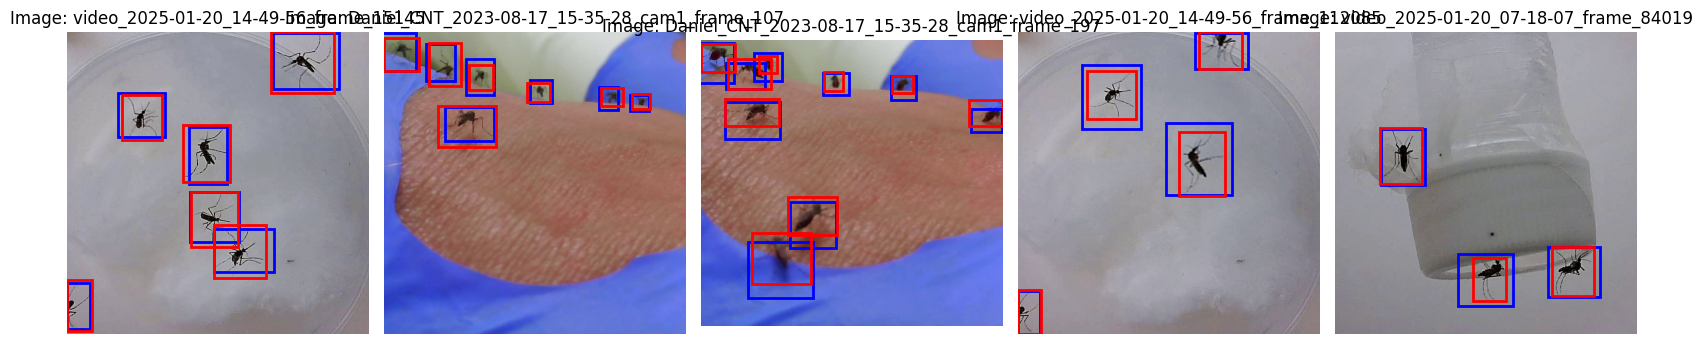

In [42]:
# Example usage
predictions_csv = "/home/wildmosquit0/workspace/data/model_exp/setups/predictions_exp1_less_crop_2002.csv"
image_folder

visualize_predictions(gt_csv, predictions_csv, image_folder, num_images=5)